In [8]:
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

In [ ]:
sp.special.kv()

In [13]:
this = np.arange(10)
that = np.where(this==3)[0]
this[that]

array([3])

In [86]:
this = np.abs(np.arange(21) - 10)
print(this)
this_ones = np.where(this==1)
print(this_ones)

[10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10]
(array([ 9, 11]),)


In [115]:
def correlation_matern(rho, rho0, nu=2.5):                                                                                                                                                                                                                                                                             
    rho1 = np.sqrt(2 * nu) * np.abs(rho) / rho0                                                                                                             

    zero_indices = np.where(rho1 == 0)[0]                                                                                                                                   

    c = (rho1 ** nu 
         * sp.special.kv(nu, rho1) 
         / sp.special.gamma(nu) 
         / 2.0 ** (nu - 1))                                                                              
    c[zero_indices] = 1.0
    
    return c

In [48]:
def correlation_exp(rho, rho0, dummy):
    c = np.exp(-np.abs(rho/rho0))
    return c

In [119]:
def correlation_sqd_exp(rho, rho0, dummy):
    c = np.exp(-(rho**2 / (2 * rho0**2)))
    return c

In [72]:
rho = np.arange(10)
rho0 = 10
nu = .5

In [79]:
print(nu)
correlation_matern(rho, rho0, nu)

100
[nan]


/Users/harty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


array([1.        , 0.99496236, 0.98000271, 0.9555731 , 0.92240139,
       0.88145491, 0.8338932 , 0.78101311, 0.72418991, 0.66481809])

In [74]:
correlation_exp(rho, rho0, nu)

array([1.        , 0.90483742, 0.81873075, 0.74081822, 0.67032005,
       0.60653066, 0.54881164, 0.4965853 , 0.44932896, 0.40656966])

In [130]:
rho = np.arange(10)
rho0 = 10
nu = 150

In [131]:
print(nu)
correlation_matern(rho, rho0, nu)

150


/Users/harty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


array([1.        , 0.99497918, 0.98006845, 0.95571542, 0.92264105,
       0.88180398, 0.83435417, 0.78157885, 0.72484455, 0.66553864])

In [122]:
correlation_sqd_exp(rho, rho0, nu)

array([1.        , 0.99501248, 0.98019867, 0.95599748, 0.92311635,
       0.8824969 , 0.83527021, 0.78270454, 0.72614904, 0.66697681])

In [135]:
np.zeros([rho.size, rho.size])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [194]:
def makeCorrelationMatrix(rho, rho0, correlation, nu=None):                                                                                                                                                                                                                                                               
    Nx = rho.size                                                                                                                                              
    cor_vec = correlation(rho, rho0, nu)                                                                                                                                                                                                                                                                        
    C = np.zeros([Nx, Nx])                                                                                                                                                                                                                                                                                          
    cor_vec = np.concatenate([cor_vec[:0:-1], cor_vec])                                                                                                                                                                                          
    for i in range(Nx):
        C[i] = cor_vec[Nx-1 - i:2 * Nx - 1 - i]
    return C

In [210]:
rho = np.arange(100, dtype=float)
rho -= rho.mean()
rho = np.abs(rho)
rho0 = 50

In [211]:
C = makeCorrelationMatrix(rho, rho0, correlation_sqd_exp)

(-0.5, 99.5, 99.5, -0.5)

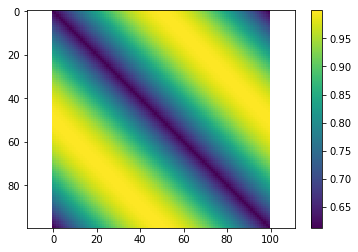

In [212]:
plt.figure()
im = plt.imshow(C)
plt.colorbar(im)
plt.axis('equal')